In [391]:
import tensorflow as tf
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import mplfinance as mpf
import talib as talib
import numpy as np
import data as ds
import common as common
import os as os
import datetime as datetime
from mplfinance.original_flavor import candlestick_ohlc
from datetime import datetime, timedelta
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [392]:
# 环境设定
pd.options.mode.chained_assignment = None
# 不让程序占满 GPU 内存
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [393]:
# 数据源 v1
file_1 = os.path.abspath(os.path.join('data', 'nq', '20201020_064100.csv'))
file_2 = os.path.abspath(os.path.join('data', 'nq', '20201023_064200.csv'))
df1 = pd.read_csv(file_1)
df2 = pd.read_csv(file_2)

# 数据源 v2
file_3 = os.path.abspath(os.path.join('data', 'nq', 'nq-20201029.csv'))
_df1 = pd.read_csv(file_3)

In [394]:
# 1.0 reshapre dataframe v1 重構數據集
df1.index = pd.to_datetime(df1.stime)
df2.index = pd.to_datetime(df2.stime)
df3 = pd.concat([df1, df2], axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
df3 = df3.rename(columns={"high": "High", "low": "Low", "open": "Open", "last": "Close", "vol": "Accumulated Volume"})
df3['udate'] = pd.to_datetime(df3['udate'])
df3['interactive_udate'] = pd.to_datetime(df3['interactive_udate'])
df3['mdate'] = pd.to_datetime(df3['mdate'])
df3['stime'] = pd.to_datetime(df3['stime'])
shape = df3.shape
types = df3.dtypes
types1 = {'High': 'float64', 'Low': 'float64', 'Open': 'float64', 'Close': 'float64', 'Accumulated Volume': 'int64', 'chng': 'float64', 'pchng': 'float64'}
df3.astype(types1).dtypes

# 1.0 reshapre dataframe v2 重構數據集
_df1.columns = ['udate', 'High', 'Low', 'Open', 'Close', 'Volume']
types2 = {'udate': 'object', 'High': 'float64', 'Low': 'float64', 'Open': 'float64', 'Close': 'float64', 'Volume': 'int64'}
_df1.astype(types2).dtypes
_df2 = _df1.copy(deep=True)
error_row = []
for k, v in _df1.iterrows():
    if not pd.isnull(_df1['udate'].iloc[k]):
        stime = str(int(_df1['udate'].iloc[k]))
        _df2['udate'].iloc[k] = datetime(year=2020, month=int(stime[-8:-6]), day=int(stime[-6:-4]), hour=int(stime[-4:-2]), minute=int(stime[-2:]), second=0)
    else:
        error_row.append(k)
_df2.drop(_df2.index[error_row], inplace=True)
_df2.udate = pd.to_datetime(_df2.udate)
_df2.index = pd.to_datetime(_df2.udate)
df3 = _df2.copy(deep=True)

# 1.2 zero / nan 數據有效性檢查
for k, v in types2.items():
    if (df3[k].isin([np.nan]).any().any()):
        print(k+' obtains nan')
    if (df3[k].isin([0]).any().any()):
        print(k+' obtains 0')
# 1.3 overview
is_contain_nan = df3.isnull().sum()

Volume obtains 0


In [395]:
# 2.0 technical indicator
highs = np.array(df3['High'], dtype='float')
lows = np.array(df3['Low'], dtype='float')
opens = np.array(df3['Open'], dtype='float')
closes = np.array(df3['Close'], dtype='float')
vols = np.array(df3['Volume'], dtype='float')
# 2.1 SMA 均線
for v in [5, 10, 20, 50, 80, 100, 120, 150, 180, 200]:
    df3['sma-'+str(v)]= talib.SMA(closes, timeperiod=v)
# 2.2 Bollinger 保力加
df3['upper-band'], df3['middle-band'], df3['lower-band'] = talib.BBANDS(closes, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
# 2.3 %B %保力加
df3['%b'] = (df3['Close']-df3['lower-band'])/(df3['upper-band']-df3['lower-band'])*100
df3['%b-high']  = common.percentB_belowzero(df3['%b'], df3['Close']) 
df3['%b-low'] = common.percentB_aboveone(df3['%b'], df3['Close'])
# 2.4 OBV 能量潮
df3['obv'] = talib.OBV(closes, vols)
# 2.5 vol EMA
df3['vol-ema5'] = talib.EMA(vols, timeperiod=5)
# 2.6 P-SAR 抛物线
df3['p-sar'] = talib.SAR(highs, lows, acceleration=0.02, maximum=0.2)
# 2.7 vwap 成交量加權平均價格
min_max_scaler, standar_scaler = MinMaxScaler(), StandardScaler()
period, vwap, vwap2 = [5, 20, 50, 100], [], []
for v in period:
    df3['typical-price'] = (df3['High'] + df3['Low'] + df3['Close']) / 3
    df3['turnover'] = df3['typical-price'] * df3['Volume']
    df3['cum-turnover-'+str(v)] = df3['turnover'].rolling(window=v).sum()
    df3['cum-volume-'+str(v)] = df3['Volume'].rolling(window=v).sum()
    df3['vwap-'+str(v)] = df3['cum-turnover-'+str(v)]  /  df3['cum-volume-'+str(v)]
    df3['vwap-'+str(v)] = df3['vwap-'+str(v)].replace([np.inf, -np.inf], 0)
    df3['vwap-'+str(v)].fillna(0, inplace=True)
    drop_list = ['turnover', 'typical-price', 'cum-turnover-'+str(v), 'cum-volume-'+str(v)]
    df3.drop(drop_list, axis=1, inplace=True)
    vwap.append('vwap-'+str(v))
    vwap2.append('vwap-nor-'+str(v))
df3[vwap2] = standar_scaler.fit_transform(df3[vwap].values)
# 2.8 MACD
df3['macd'], df3['macdsignal'], df3['macdhist'] = talib.MACD(closes, fastperiod=12, slowperiod=26, signalperiod=9)

In [396]:
# 3.0 separate to daily data set
data = {}
days1 = list(dict.fromkeys([v.date() for v in df3['udate']])) # how many tradeing day
for day in days1:
    day_start = datetime(day.year, day.month, day.day, 6, 0, 0)
    day2 = day + timedelta(days=1)
    day_end = datetime(day2.year, day2.month, day2.day, 6, 0, 0)
    mask = ((df3['udate'] >= day_start) & (df3['udate'] <= day_end))
    df4 = df3.loc[mask]
    if (df4.shape[0] > 1):
        data[day] = df4

In [397]:
# 4.0 draw chart
for k, df5 in data.items():
    # 4.1 style
    style = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size':6})
    # 4.2 addplot
    apds = [mpf.make_addplot(df5[['lower-band','upper-band']],panel=0,color='orange',linestyle='dashdot'),
            mpf.make_addplot(df5['vwap-20'].replace(0, np.nan),panel=0,color='aqua',linestyle='dashdot'),
            mpf.make_addplot(df5['%b-low'],type='scatter',markersize=20,marker='v',panel=0),
            mpf.make_addplot(df5['%b-high'],type='scatter',markersize=20,marker='^',panel=0),
            mpf.make_addplot(df5['p-sar'],scatter=True,markersize=1,marker='*',panel=0,color='blueviolet'),
            mpf.make_addplot(df5['vol-ema5'],panel=1,color='orange'),
            mpf.make_addplot(df5[['macd', 'macdsignal', 'macdhist']],panel=2)]
    # 4.3 render
    if (True):
        # print(df5.shape, df5['udate'].iloc[0], df5['udate'].iloc[-1])
        mpf.plot(df5, type='candle', addplot=apds, style=style, ylabel='', ylabel_lower='', volume=True, figscale=1.25, xrotation=0, datetime_format="%H:%M", show_nontrading=False, tight_layout=True, savefig='./data/img-nq/features/'+k.strftime('%m-%d-%Y')) 

In [398]:
# 5.0 合併
df7 = pd.DataFrame()
for k, df6 in data.items():
    df7 = pd.concat([df7, df6], axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
# 5.1.1 清洗
df8 = df7.copy(deep=True)
drop_list = ['udate', 'High', 'Low', 'Open', 'Volume']+vwap # drop_list = ['udate', 'code', 'name', 'nmll', 'bid', 'ask', 'bsize', 'asize', 'clast', 'Accumulated Volume', 'turnover', 'currency',  'yrhigh', 'yrlow', 'tnover_sc', 'lotsize', 'calllv', 'issued', 'ichng', 'ucode', 'ratio', 'strike', 'mdate', 'issuer', 'traded', 'ocode', 'eikon_udate', 'interactive_udate', 'instrument_type', 'stime', 'udate2']
df8.drop(drop_list, axis=1, inplace=True)
df8.fillna(0, inplace=True)
is_contain_null = df8.isnull().sum()
is_contain_nan = df8.isna().sum()
print('数据集: Total dataset has {} samples, and {} features.'.format(df8.shape[0], df8.shape[1])) # df8.info()
# 5.1.2 save all data to csv
path_data = os.path.abspath(os.path.join('data', 'nq', 'nq-clean-data-with-features.csv'))
if os.path.exists(path_data):
    os.remove(path_data)
df8.to_csv(path_data)
# 5.2 分包
no_day = np.array([v.shape[0] for k, v in data.items()])
no_day_1, no_day_2 = no_day[:-2].sum(), no_day.sum()
train_data = df8.iloc[200 : no_day_1]
test_data = df8.iloc[no_day_1 : no_day_2]
print('分包: Train Data: {}, Test Data: {}'.format(train_data.shape, test_data.shape))
# 5.3 模型数据
# 5.3.1 train data
x_train, y_train = [], []
for k, v in train_data.iterrows():
    x_train.append(v.tolist())
    y_train.append(v['Close'])
x_train, y_train =  np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],  x_train.shape[1],  1))
print('訓練集: X_train Data: {}, Y_train Data: {}'.format(x_train.shape, y_train.shape))
# 5.3.2 test data
x_test, y_test = [], []
for k, v in test_data.iterrows():
    x_test.append(v.tolist())
    y_test.append(v['Close'])
x_test, y_test =  np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],  x_test.shape[1],  1))
print('測試集: X_Test Data: {}, Y_Test Data: {}'.format(x_test.shape, y_test.shape))

数据集: Total dataset has 28600 samples, and 27 features.
分包: Train Data: (26008, 27), Test Data: (2392, 27)
訓練集: X_train Data: (26008, 27, 1), Y_train Data: (26008,)
測試集: X_Test Data: (2392, 27, 1), Y_Test Data: (2392,)


In [400]:
# 6.0.1 模型参数
batch_size = 50
epochs = 3  # 80
units = 1000 # 1000
# 6.0.2 日志参数
prefix = 'nq-lstm'
cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# 6.1 模型
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(tf.keras.layers.LSTM(units=units, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(tf.keras.layers.LSTM(units=units, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(tf.keras.layers.LSTM(units=units, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(units=1))
model_lstm.add(Dropout(0.2))
model_lstm.compile(optimizer='rmsprop', loss='mean_squared_logarithmic_error', metrics=['accuracy', 'mae', 'sparse_categorical_accuracy'])
model_lstm.summary()

# 6.2.1 創建check point
checkpoint_dir = './training_checkpoints/'+ prefix +'-' + cur_time
os.mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

# 6.2.2 創建tensor board
log_dir = os.path.join('./logs/fit/'+ prefix +'-') + cur_time
os.mkdir(log_dir)
tensor_board_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# 6.3 fit model
history_lstm = model_lstm.fit(x_train, x_train, epochs = epochs, batch_size = batch_size, 
                              validation_data = (x_test, y_test),
                              callbacks=[checkpoint_callback, tensor_board_callback])

# 6.4 儲存模型
model_path = "./saved_model/nq_lstm_"+cur_time+".h5"
model_lstm.save(model_path)

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_170 (LSTM)              (None, 27, 1000)          4008000   
_________________________________________________________________
dropout_211 (Dropout)        (None, 27, 1000)          0         
_________________________________________________________________
lstm_171 (LSTM)              (None, 27, 1000)          8004000   
_________________________________________________________________
dropout_212 (Dropout)        (None, 27, 1000)          0         
_________________________________________________________________
lstm_172 (LSTM)              (None, 27, 1000)          8004000   
_________________________________________________________________
dropout_213 (Dropout)        (None, 27, 1000)          0         
_________________________________________________________________
lstm_173 (LSTM)              (None, 27, 1000)        

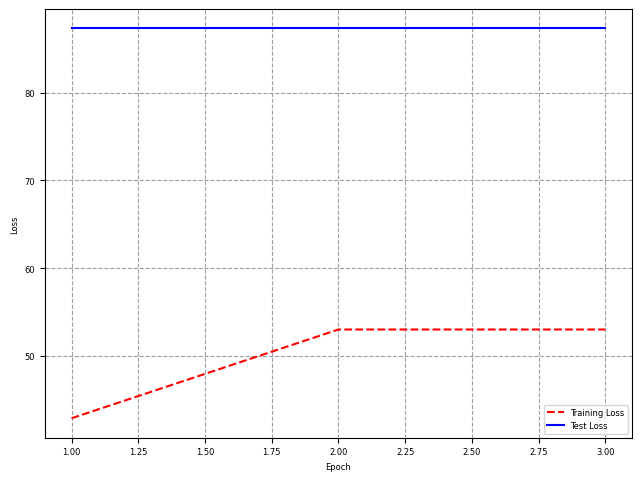

In [401]:
# 7.0 visualize model
keys = list(history_lstm.history.keys())
training_loss = history_lstm.history['loss']
test_loss = history_lstm.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig('./data/img-nq/results/'+cur_time)

In [402]:
# 8.0 prediction
